In [2]:
import os; os.chdir("../")
import sys; sys.path.append("scripts")

In [3]:
import re
import torch
import yaml
from utils import set_seed, init_tokenizer
from utils import HF_NAME_MAP
from utils import RegexStopAndExtractCriteria
from transformers import (
    BitsAndBytesConfig,
    AutoModelForCausalLM, AutoTokenizer,
    GenerationConfig, 
    StoppingCriteriaList, LogitsProcessorList,
    MaxTimeCriteria, LogitsProcessor, StoppingCriteria
)

config_path = 'configs/basic.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
set_seed(config['seed'])



In [4]:
from datasets import load_from_disk, concatenate_datasets, load_dataset, Dataset

In [1]:
# dset = load_from_disk("/home/chanwoo/chanwoo/repo/verifier/data/sft_llama-8b_gsm8k_correct_100_0_")
# new_q = tokenizer.batch_decode(dset['question'], skip_special_tokens=True)
# new_q2 = [q.split("Question: ")[1] for q in new_q]
# new_dset = {
#     "question": new_q2,
#     "answer": dset['answer']
# }
# new_dset_obj = Dataset.from_dict(new_dset)
# new_dset_obj.save_to_disk("data/sft_llama-8b_gsm8k_correct_100_0")

In [ ]:
prompt = """
Answer the question below. The final answer should be number and write the final answer after the \n####. For example, \n#### 000
Question : Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
"""

In [ ]:
prompt = """
Validate the solution for the question below.
Question : Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Answer: She eats 3 x 16 = <<3*16=48>>48 fresh duck eggs per day.\nShe sells 48 x 2 = <<48*2=96>>96 fresh duck eggs at the farmers' market.\nShe makes 96 x $2 = $<<96*2=192>>192 every day at the farmers' market.\n#### 192
"""

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
# import subprocess
# from transformers import BitsAndBytesConfig, QuantoConfig
# test_qt_configs = [
#     BitsAndBytesConfig(load_in_4bit=True),
#     BitsAndBytesConfig(load_in_8bit=True),
#     QuantoConfig(weights="int8"),
# ]

# def get_gpu_memory_by_pid(pid):
#     try:
#         # nvidia-smi로 프로세스 정보 조회
#         result = subprocess.run(
#             ["nvidia-smi", "--query-compute-apps=pid,used_memory", "--format=csv,noheader,nounits"],
#             stdout=subprocess.PIPE, text=True
#         )

#         # 결과 파싱
#         processes = result.stdout.strip().split("\n")
#         for process in processes:
#             process_info = process.split(", ")
#             process_pid = int(process_info[0])
#             used_memory = int(process_info[1])  # GPU 메모리 사용량 (MB 단위)

#             if process_pid == pid:
#                 return used_memory
#         return None  # 해당 PID가 GPU에서 실행 중이지 않음

#     except FileNotFoundError:
#         print("nvidia-smi 명령어를 찾을 수 없습니다. NVIDIA 드라이버가 설치되어 있는지 확인하세요.")
#         return None
#     except Exception as e:
#         print(f"에러 발생: {e}")
#         return None

# # 예시: 특정 PID의 GPU 메모리 사용량 확인
# pid = 5765  # 확인하려는 PID
# gpu_memory = get_gpu_memory_by_pid(pid)
# if gpu_memory is not None:
#     print(f"PID {pid}의 GPU 메모리 사용량: {gpu_memory} MB")
# else:
#     print(f"PID {pid}는 GPU에서 실행 중이지 않습니다.")

# model_name = "sft_llama-1b"
# task_name = "gsm8k"
# model_path = f"models/{model_name}_{task_name}"
# model_type, pt_name = model_name.split("_")
# hf_name = HF_NAME_MAP[pt_name]

# pid = os.getpid()

# for qt in test_qt_configs:
#     model = AutoModelForCausalLM.from_pretrained(
#         model_path,
#         quantization_config=qt,
#         **config['model'][pt_name]
#     )
#     gpu_memory = get_gpu_memory_by_pid(pid)
#     print(f"QT: {qt}, GPU Memory: {gpu_memory} MB")
#     model.cpu()
#     del model

#     torch.cuda.empty_cache()

In [8]:
model_name = "sft_llama-1b"
task_name = "gsm8k"
model_path = f"models/{model_name}_{task_name}"

model_type, pt_name = model_name.split("_")
hf_name = HF_NAME_MAP[pt_name]
tokenizer = AutoTokenizer.from_pretrained(hf_name)
init_tokenizer(tokenizer)
model = AutoModelForCausalLM.from_pretrained(
    # model_path,
    "models/sft_llama-1b_gsm8k_star_0",
    # quantization_config=BitsAndBytesConfig(load_in_4bit=True),
    **config['model'][pt_name]
)

In [ ]:
instruction = "Please calculate the solution step-by-step and conclude the answer with \n#### followed by the result.\n"
query = instruction + "'A fruit vendor bought 50 watermelons for $80. He sold all of them at a profit of 25%. How much was each watermelon sold? Answer: "

In [ ]:
input_token = tokenizer(query, return_tensors='pt')

In [ ]:
class CustomLogitsProcessor(LogitsProcessor):
    def __init__(self, pattern, tokenizer):
        """
        Args:
            pattern (str): 탐지할 정규식 패턴.
            tokenizer (Tokenizer): 토크나이저 객체.
        """
        self.pattern = pattern
        self.tokenizer = tokenizer

    def __call__(self, input_ids, scores):
        """
        Args:
            input_ids (torch.Tensor): (n_samples, seq_len) 형태의 입력 토큰 ID.
            scores (torch.Tensor): (n_samples, n_vocab) 형태의 로그 확률 점수.

        Returns:
            torch.Tensor: 수정된 로그 확률 점수.
        """
        pad_token = self.tokenizer.pad_token_id

        for i in range(input_ids.size(0)):
            # 전체 시퀀스를 디코딩
            decoded = self.tokenizer.decode(input_ids[i])
            # 패턴이 디코딩된 텍스트에서 발견되면 처리
            if re.search(self.pattern, decoded):
                scores[i, :] = -1e9  # 모든 토큰 비활성화
                scores[i, pad_token] = 0  # pad_token만 활성화

        return scores

In [ ]:
res = model.generate(
    inputs=input_token.input_ids.to(model.device),
    generation_config=GenerationConfig(
        max_length=256,
        do_sample=True,
        temperature=0.7,
        num_beams=1,
        num_return_sequences=16
    ),
    logits_processor=LogitsProcessorList([
        CustomLogitsProcessor(pattern=r"####\s*-?\d+(\D)", tokenizer=tokenizer)
    ])
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [ ]:
print(res.shape)

for i in range(res.size(0)):
    text = tokenizer.decode(res[i], skip_special_tokens=True)
    answer_part = text.split("Answer: ")[-1]
    print(f"{i}: {answer_part}")

torch.Size([16, 205])
0: 80 x 25/100 = <<80*25/100=20>>20% of the watermelons were sold.
So, 80 - 20 = <<80-20=60>>60% of the watermelons were not sold.
Therefore, 60 / 100 x 50 = <<60/100*50=30>>30 watermelons were sold.
Thus, each watermelon sold was $80 x 30 / 60 = $<<80*30/60=20>>20.
#### 20

1: 80/100 * 50 = $<<80/100*50=40>>40
Since 25% is 25/100 * 100% = 25%, this means that 100 - 25 = 75% of the watermelons were sold.
Thus, each of the watermelons was sold for 40 / 75 = $<<40/75=0.4>>0.4
#### 0.
2: 25% of the price of 1 watermelon is $0.25 * 80 = $<<0.25*80=20>>20.
So the total profit was $80 - $20 = $<<80-20=60>>60.
Therefore, each watermelon was sold at $80 / 60 = $<<80/60=1.333>>1.333.
#### 1.
3: 80 / 25 = $<<80/25=32>>32 per watermelon
The fruit vendor sold all of the watermelons at $32 each, which is 50 x $32 = $<<50*32=1600>>1600
#### 1600

4: 80/25 = $<<80/25=3>>3 per watermelon.
50 * $3 = $<<50*3=150>>150
#### 150

5: 80-80=<<80-80=0>>0
Therefore, each watermelon was so

In [ ]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
prompt = "The capital of France is"
label = " Paris"  # Likelihood를 계산하고 싶은 레이블

# 전체 입력 텍스트
input_text = prompt + label
input_ids = tokenizer([input_text], return_tensors="pt").input_ids
label_ids = tokenizer([label], return_tensors="pt").input_ids

with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits  # (batch_size, sequence_length, vocab_size)

# label 토큰의 likelihood 추출
# Prompt 길이 이후의 토큰만 고려
label_start_idx = len(tokenizer(prompt, return_tensors="pt").input_ids[0])
logits_for_labels = logits[0, label_start_idx - 1 : -1, :]  # (label_length, vocab_size)

# Label의 토큰 ID
label_token_ids = label_ids[0]

# Log-Softmax 계산
log_probs = torch.log_softmax(logits_for_labels, dim=-1)

# 각 레이블 토큰의 로그 확률 합산
label_likelihood = log_probs[range(len(label_token_ids)-1), label_token_ids].sum()
print(f"Log-Likelihood of the label: {label_likelihood.item()}")



Log-Likelihood of the label: -23.194427490234375


In [ ]:
prompt = "The capital of France is"
label = " Madrid"  # Likelihood를 계산하고 싶은 레이블

# 전체 입력 텍스트
input_text = prompt + label
input_ids = tokenizer([input_text], return_tensors="pt").input_ids
label_ids = tokenizer([label], return_tensors="pt").input_ids

with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits  # (batch_size, sequence_length, vocab_size)

# label 토큰의 likelihood 추출
# Prompt 길이 이후의 토큰만 고려
label_start_idx = len(tokenizer(prompt, return_tensors="pt").input_ids[0])
logits_for_labels = logits[0, label_start_idx - 1 : -1, :]  # (label_length, vocab_size)

# Label의 토큰 ID
label_token_ids = label_ids[0]

# Log-Softmax 계산
log_probs = torch.log_softmax(logits_for_labels, dim=-1)

# 각 레이블 토큰의 로그 확률 합산
label_likelihood = log_probs[range(len(label_token_ids)-1), label_token_ids].sum()
print(f"Log-Likelihood of the label: {label_likelihood.item()}")



Log-Likelihood of the label: -31.83171844482422


In [ ]:
input_ids, label_ids

(tensor([[128000,    791,   6864,    315,   9822,    374,  25048]]),
 tensor([[128000,  25048]]))

In [ ]:
logits.shape

torch.Size([1, 7, 128256])

In [ ]:
logits_for_labels.shape

torch.Size([1, 128256])

In [ ]:
log_probs.shape

torch.Size([1, 128256])

In [ ]:
len(label_token_ids)

2

In [ ]:
label_token_ids

tensor([128000,  12366])

In [ ]:
STOP

In [ ]:
activation = {}

def get_activation(layer_nm):
    def hook(module, input, output):
        if layer_nm == "self_attn":
            output = output[0]
        activation[layer_nm] = output.detach().cpu()
    return hook
self_attn = model.model.layers[-1].self_attn
mlp = model.model.layers[-1].mlp
handler1 = self_attn.register_forward_hook(get_activation('self_attn'))
handler2 = mlp.gate_proj.register_forward_hook(get_activation('gate_proj'))

In [ ]:
text = "The quick brown fox jumps over the lazy dog"
input_ids = tokenizer.encode(text, return_tensors="pt")
output = model(input_ids)
handler1.remove()
handler2.remove()

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [ ]:
input_ids.shape, activation['self_attn'].shape, activation['gate_proj'].shape

(torch.Size([1, 10]), torch.Size([1, 10, 2048]), torch.Size([1, 10, 8192]))

In [ ]:
neurons = mlp.act_fn(activation['gate_proj'][0, -1])

In [ ]:
neurons.max(), neurons.min(), neurons.mean(), neurons.std()

(tensor(6.7227, dtype=torch.float16),
 tensor(-0.2786, dtype=torch.float16),
 tensor(0.0792, dtype=torch.float16),
 tensor(0.3706, dtype=torch.float16))

In [ ]:
import matplotlib.pyplot as plt

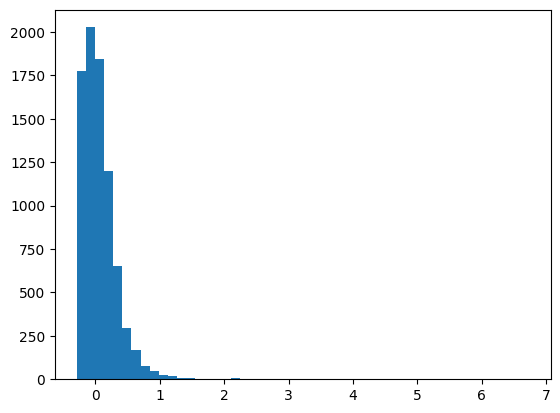

In [ ]:
plt.hist(neurons.numpy(), bins=50)
plt.show()

In [ ]:
neurons

tensor([-0.0828,  0.3142,  0.0468,  ...,  0.1896,  0.0750,  0.0922],
       dtype=torch.float16)

In [ ]:
thres = neurons.float().quantile(0.99)
torch.where(neurons > thres)

(tensor([  41,  100,  287,  396,  402,  576,  640,  840,  870,  936, 1070, 1071,
         1143, 1210, 1327, 1346, 1401, 1546, 1579, 1619, 1787, 1788, 1879, 1949,
         2027, 2059, 2072, 2260, 2307, 2545, 2548, 2627, 2636, 2773, 2785, 2859,
         2999, 3106, 3307, 3316, 3449, 3497, 3675, 3879, 4407, 4549, 4587, 4758,
         4775, 4807, 4811, 4817, 4870, 4909, 5394, 5450, 5621, 5782, 5792, 5881,
         5924, 6036, 6278, 6283, 6364, 6517, 6747, 6805, 6813, 6853, 6888, 7006,
         7358, 7375, 7598, 7670, 7728, 7811, 7874, 7996, 8092, 8120]),)

In [ ]:
thres

tensor(1.1087)